In [7]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import r2_score

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils, ml_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TO DO
- ~~pipeline~~
- ~~full parameter sweep~~
- ~~other models? NN?~~
- ~~feature importance visualisation~~
- Does CCA disappear on grouping?
- Test NN – pytorch?
- add synthetic as train data source
- emulate S2 from validation spectra
- fix plotting shading
- visualise by site/depth

In [2]:
# load features (spectra)
raw_spectra = spectrum_utils.load_spectra()
validation_spectra = spectrum_utils.preprocess_prism_spectra(raw_spectra, spectrum_utils.NIR_WAVELENGTHS, spectrum_utils.SENSOR_RANGE)

In [3]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

,X,Y,Campaign,Locale,Station,TimeUTC,TimeLocal,Depth,Metabolism,Optics,...,othInvert,othOther,othSponge,othUrchin,sedLimest,sedMud,sedRubble,sedSand,ROInumber,Flightline
0,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
1,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
2,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
3,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
4,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img


In [50]:
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="four_endmember").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 1550
N features: 84
N test samples: 388
Label dimensions: 4


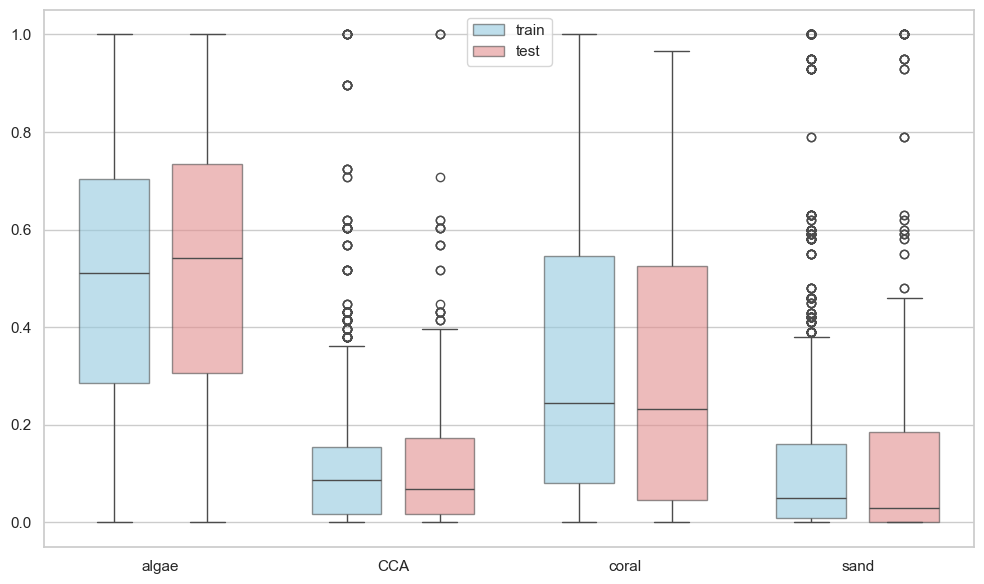

In [51]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [52]:
# best_gbr = ml_utils.sklModels(model_type="gradient_boosting").return_fitted_model(X_train, y_train)
best_rf = ml_utils.sklModels(model_type="random_forest").return_fitted_model(X_train, y_train)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - to python to disabl

RandomizedSearchCV took 96.32 seconds for 50 candidates parameter settings.


NameError: name 'ml_utils' is not defined

In [ ]:
plotting.initialise_square_plot_grid(4)

In [14]:
# predict
y_pred_rf = best_rf.predict(X_test)
y_pred_gbr = best_gbr.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"R^2 for RandomForest: {r2_rf:.3f}")
print(f"R^2 for MultiOutputGradientBoosted: {r2_gbr:.3f}")

R^2 for RandomForest: 0.769
R^2 for MultiOutputGradientBoosted: 0.765


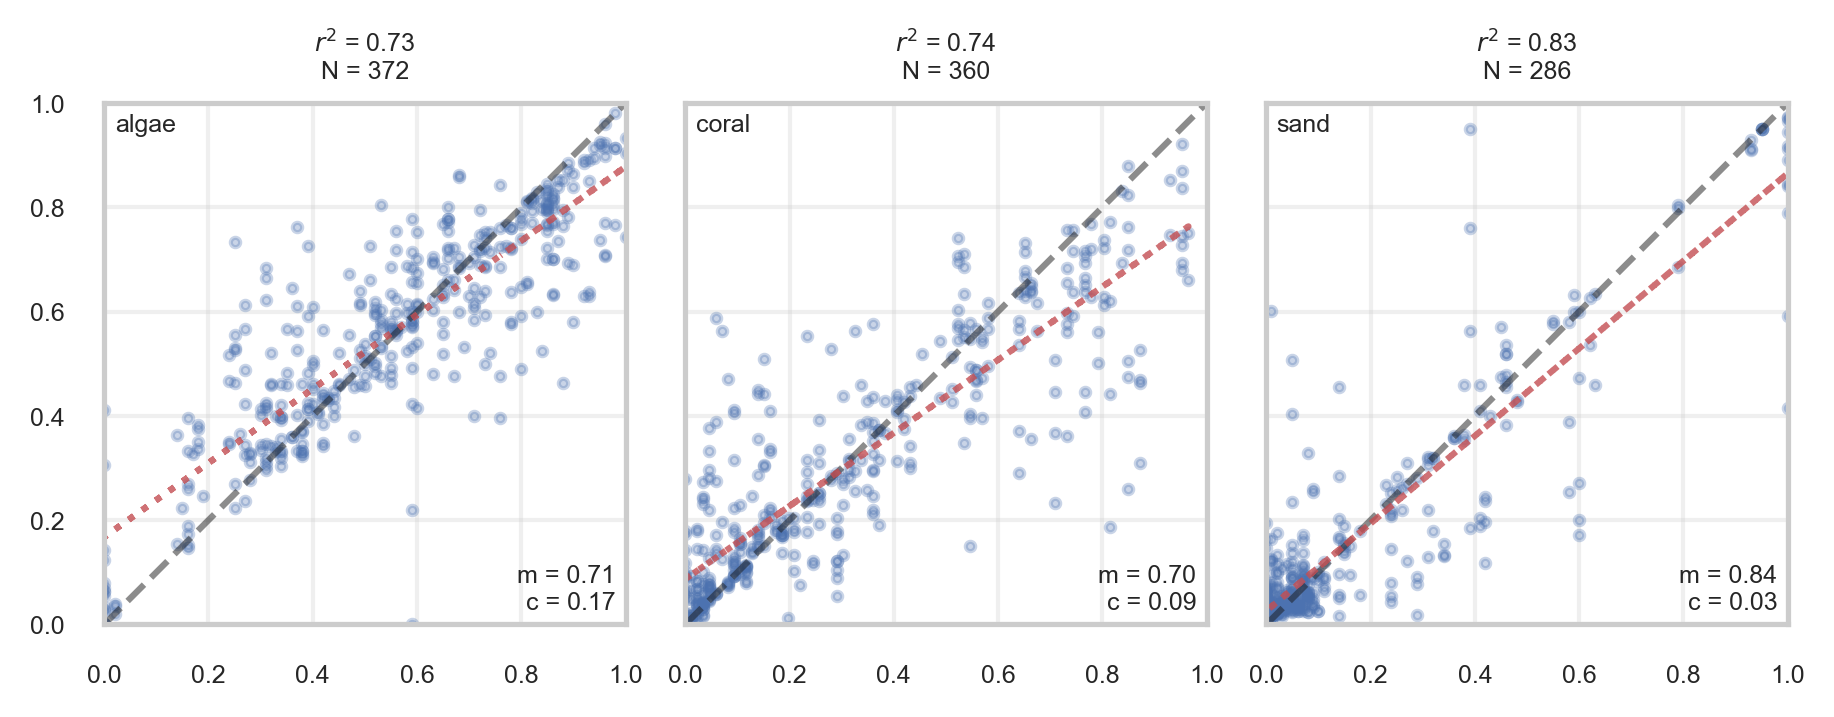

In [49]:
test_data = y_test
pred_data = y_pred_rf

ml_utils.plot_regression_results(test_data, pred_data, labels)

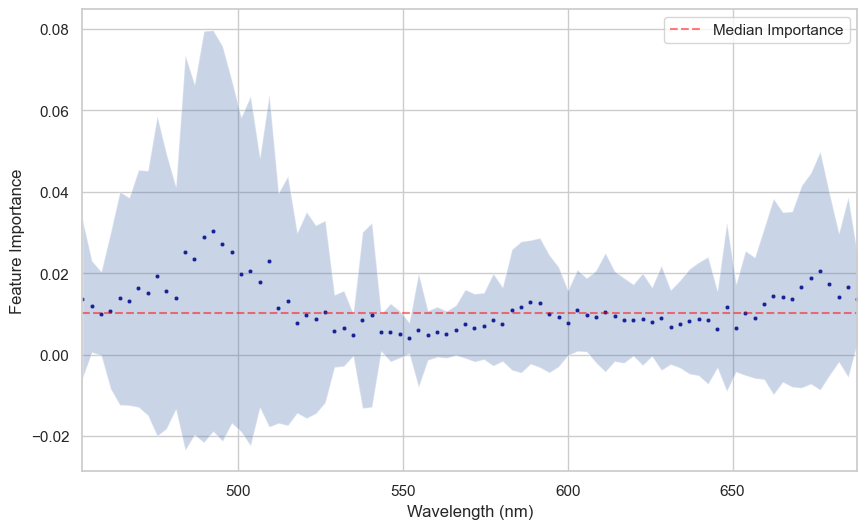

In [43]:
# plot a scatterplot of mean importance, with std shaded
rf_importances = np.array([tree.feature_importances_ for tree in best_rf.estimators_])
importance_df = pd.DataFrame(rf_importances, columns=X_train.columns).agg(["mean", "std"]).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=importance_df.index, y=importance_df["mean"], s=10, ax=ax, color="darkblue")
ax.fill_between(importance_df.index, importance_df["mean"] - importance_df["std"], importance_df["mean"] + importance_df["std"], alpha=0.3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Feature Importance")
ax.set_xlim(min(importance_df.index), max(importance_df.index))
ax.hlines(np.median(importance_df["mean"]), min(importance_df.index), max(importance_df.index), linestyle="--", alpha=0.5, color="red", label="Median Importance")
ax.legend()